# Boosted Decision Tree
Use 30% of the data to train a BDT

In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import awkward as ak

In [2]:
def get_config(is_jaguar=False):
    config = dict()
    config["data"] = dict()
    if is_jaguar:
        config["data"] = {
            "files" : "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/cuts30/*.root",
            "workers" : 45,
            "step_size" : "500 MB",
        }
        config["tree_dir"] = "/home/cpegueros/bdt/"
        config["tree_to_use"] = "/home/cpegueros/bdt/gradient_1627012989.joblib"
        config["data_classified"] = "/storage/cpegueros/data_classified.csv"
    else:
        config["data"] = {
            "files" : None,
            "workers" : None,
            "step_size" : None,
        }
        config["tree_dir"] = None
        # este BDT es el bueno
        config["tree_to_use"] = "/home/peguerosdc/development/thesis/data/gradient_1627012989.joblib"
        config["data_classified"] = "/home/peguerosdc/development/thesis/data/data_classified.csv"
    return config

In [4]:
# set variables to use
branches_to_train = ["thrust","visibleEnergyOfEventCMS","track_sig_EoverP","track_sig_pionID","track_sig_pt", "sig_gamma1_E","sig_gamma2_E","track_sig_cosToThrustOfEvent","neutral_sig_E","neutral_sig_M"]
branches_to_cut = ["tauPlusMCMode", "tauMinusMCMode", "track_sig_charge", "tau_sig_InvM", "nPi0s_sig"]
branches_to_use = branches_to_train + branches_to_cut
print(f"Going to use {len(branches_to_train)} variables to fit...")

Going to use 10 variables to fit...


Read the data to create the dataset (takes around 217s)

In [3]:
# choose files
config = get_config(is_jaguar=True)

# read with cuts using ak
signal_temp = ak.Array([])
bg_temp = ak.Array([])
for df in uproot.iterate(f"{config['data']['files']}:tau1x1", filter_name=branches_to_use,step_size=config['data']['step_size'], num_workers=config['data']['workers']):
    one_pi0 = df[(df.nPi0s_sig==1)]
    # get the events that are signal
    is_signal = \
    (( (one_pi0.track_sig_charge==1) & (one_pi0.tauPlusMCMode==4) ) | (
        (one_pi0.track_sig_charge==-1) & (one_pi0.tauMinusMCMode==4)
    ))
    signal_temp = ak.concatenate([signal_temp, one_pi0[is_signal]], axis=0)
    # get the events that are background
    is_bg = \
        (( (one_pi0.track_sig_charge==1) & (one_pi0.tauPlusMCMode!=4) ) | (
            (one_pi0.track_sig_charge==-1) & (one_pi0.tauMinusMCMode!=4)
        ))
    bg_temp = ak.concatenate([bg_temp, one_pi0[is_bg]], axis=0)
# convert everything to pandas
signal = ak.to_pandas(signal_temp).drop(columns=["nPi0s_sig"])
signal["is_signal"] = 1
print(f"Signal events       :  {len(signal)}")
background = ak.to_pandas(bg_temp).drop(columns=["nPi0s_sig"])
background["is_signal"] = 0
print(f"Background events   :  {len(background)}")
# concat all in one data set and save it
data = pd.concat([signal, background], ignore_index=True)
data.to_csv(config["data_classified"])
print(f"Data saved at {config['data_classified']}")
data

Going to use 10 variables to fit...
Signal events       :  1650061
Background events   :  528058
Data saved at /storage/cpegueros/data_classified.csv


,thrust,visibleEnergyOfEventCMS,tauMinusMCMode,tauPlusMCMode,tau_sig_InvM,neutral_sig_E,neutral_sig_M,track_sig_pt,track_sig_charge,track_sig_cosToThrustOfEvent,track_sig_EoverP,track_sig_pionID,sig_gamma1_E,sig_gamma2_E,is_signal
0,0.850522,1.474828,3.0,4.0,0.808521,0.698558,0.128000,0.671802,1.0,0.841184,0.434246,1.000000,0.414465,0.284093,1
1,0.968179,2.802266,1.0,4.0,0.688970,1.275417,0.137439,1.019209,1.0,-0.951703,0.187453,0.999286,0.258614,1.016802,1
2,0.914588,1.468927,4.0,2.0,0.657552,0.355679,0.134537,0.862164,-1.0,-0.972805,0.222826,0.999996,0.140067,0.215613,1
3,0.939378,2.760144,1.0,4.0,0.661845,2.038051,0.139492,0.568888,1.0,0.944906,0.170513,0.999999,1.316965,0.721087,1
4,0.962692,5.584837,4.0,2.0,1.062795,2.596673,0.122394,1.559959,-1.0,-0.973305,0.215762,0.998634,1.456413,1.140260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178114,0.907045,2.472408,5.0,2.0,0.782497,1.407839,0.140146,0.642433,-1.0,-0.899456,0.530218,0.999989,1.079280,0.328560,0
2178115,0.961844,3.388726,5.0,2.0,0.711473,1.383999,0.137896,0.315579,-1.0,-0.678983,0.407197,1.000000,0.205244,1.178756,0
2178116,0.956421,4.142145,19.0,1.0,0.584229,0.970492,0.116936,0.294398,-1.0,-0.874111,0.631318,0.764432,0.133685,0.836807,0
2178117,0.925671,2.448000,1.0,5.0,0.593562,0.765856,0.125613,0.951617,1.0,0.909846,0.206802,1.000000,0.357182,0.408674,0


In [4]:
from sklearn.model_selection import train_test_split

# split the whole dataset into a train set and a test set
data_train, data_test = train_test_split(data, random_state=0, test_size=0.5)
# retrieve the features and targets from each set
features_train, target_train = data_train[branches_to_train], data_train["is_signal"]
features_test, target_test = data_test[branches_to_train], data_test["is_signal"]

Train the BDT

In [5]:
from sklearn.ensemble import GradientBoostingClassifier as classifier
import joblib
from datetime import datetime

# train
print(f"Training {classifier}")
model = classifier(n_estimators=100, max_depth=5, min_samples_leaf=0.05)
model = model.fit(features_train, target_train)
# Score
score = model.score(features_test, target_test)
print(f"Score = {score}")
# Save
timestamp = datetime.now().timestamp()
bdt_path = f"{config['tree_dir']}gradient_{timestamp:1.0f}.joblib"
joblib.dump(model, bdt_path)

Training <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Score = 0.7668411290470681


['/home/cpegueros/bdt/gradient_1627012989.joblib']

# Check the BDT

In [5]:
import joblib
from sklearn.model_selection import train_test_split
config = get_config(is_jaguar=False)

# load model
model = joblib.load(config["tree_to_use"])
print(f"Going to use model {model}")
# load and split data
data = pd.read_csv(config["data_classified"])
data_train, data_test = train_test_split(data, random_state=0, test_size=0.5)
features_train, target_train = data_train[branches_to_train], data_train["is_signal"]
features_test, target_test = data_test[branches_to_train], data_test["is_signal"]

Going to use model GradientBoostingClassifier(max_depth=5, min_samples_leaf=0.05)


Best Punzi value is 1899.263570647234 at 1.4659092636247288 with probability 0.8124348178431804


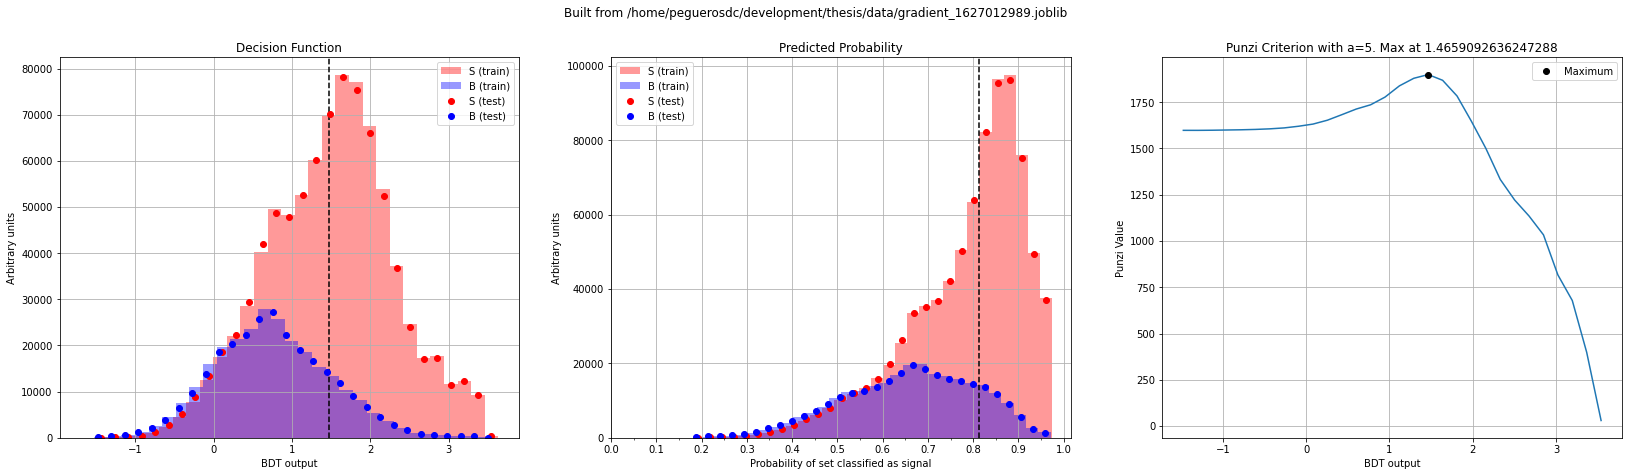

In [10]:
# plot output distribution
fig, axs = plt.subplots(1, 3, figsize=(28, 7))
fig.suptitle(f"Built from {config['tree_to_use']}")
nbins = 30

# Compute the decision function for the training set
def plot_decision_function(ax, data, is_signal=True, is_train=True):
    d_signal = model.decision_function(data).ravel()
    color = "r" if is_signal else "b"
    label = "S" if is_signal else "B"
    set_type = 'train' if is_train else 'test'
    return ax_decision.hist(d_signal, label=f"{label} ({set_type})",
        color=color, alpha=0.4, bins=nbins, histtype='stepfilled', density=False)

ax_decision = axs[0]
d_signal_hist, d_bins, _ = plot_decision_function(ax_decision, features_train[(target_train==1)], is_signal=True, is_train=True)
d_noise_hist, _, _ = plot_decision_function(ax_decision, features_train[(target_train==0)], is_signal=False, is_train=True)

# Compute the decision function for the test set
hist, bins = np.histogram(model.decision_function(features_test[(target_test==1)]).ravel(), bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_decision.errorbar(center, hist, fmt='o', c='r', label='S (test)')

hist, bins = np.histogram(model.decision_function(features_test[(target_test==0)]).ravel(), bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_decision.errorbar(center, hist, fmt='o', c='b', label='B (test)')

ax_decision.grid()
ax_decision.set_title("Decision Function")
ax_decision.set_xlabel("BDT output")
ax_decision.set_ylabel("Arbitrary units")
ax_decision.legend(loc='best')

# Compute the probabilities for the training set
ax_probs = axs[1]
d_signal = model.predict_proba(features_train[(target_train==1)])[:,1]
ax_probs.hist(d_signal,
    color='r', alpha=0.4, bins=nbins,
    histtype='stepfilled', density=False,
    label='S (train)')

d_noise  = model.predict_proba(features_train[(target_train==0)])[:,1]
ax_probs.hist(d_noise,
    color='b', alpha=0.4, bins=nbins,
    histtype='stepfilled', density=False,
    label='B (train)')
# Compute the probabilities for the test set
hist, bins = np.histogram(model.predict_proba(features_test[(target_test==1)])[:,1], bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_probs.errorbar(center, hist, fmt='o', c='r', label='S (test)')

hist, bins = np.histogram(model.predict_proba(features_test[(target_test==0)])[:,1], bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_probs.errorbar(center, hist, fmt='o', c='b', label='B (test)')

ax_probs.grid()
ax_probs.set_title("Predicted Probability")
ax_probs.set_xlabel("Probability of set classified as signal")
ax_probs.set_ylabel("Arbitrary units")
ax_probs.legend(loc='best')
_ = ax_probs.set_xticks(np.arange(0, 1.01, 0.1), minor=False)
_ = ax_probs.set_xticks(np.arange(0.05, 1, 0.1), minor=True)

# Compute Punzi criterion
punzi = []
a_sigmas = 5

# Compute all Punzi values
max_bin, max_punzi = 0, 0
for bin in range(len(d_signal_hist)):
    # Compute Punzi value p
    nsig = sum(d_signal_hist[bin:])
    nbkg = sum(d_noise_hist[bin:])
    p = nsig/(a_sigmas/2 + np.sqrt(nbkg))
    punzi.append(p)
    # Find maximum
    if p > max_punzi:
        max_bin, max_punzi = bin, p
dcenters = (d_bins[:-1] + d_bins[1:]) / 2
best_cut_threshold = dcenters[max_bin]
best_cut_probability = 1.0/(1.0 + np.exp(-1*best_cut_threshold))
print(f"Best Punzi value is {max_punzi} at {best_cut_threshold} with probability {best_cut_probability}")

# Plot
punzi_ax = axs[2]
punzi_ax.plot(dcenters, punzi)
punzi_ax.plot(best_cut_threshold, max_punzi, "ko", label="Maximum")
punzi_ax.set_title(f"Punzi Criterion with a={a_sigmas}. Max at {best_cut_threshold}")
punzi_ax.set_xlabel("BDT output")
punzi_ax.set_ylabel("Punzi Value")
punzi_ax.grid()
_ = punzi_ax.legend(loc='best')

# Show also on the previous axes
_ = ax_decision.axvline(best_cut_threshold, linestyle="--", color="black")
_ = ax_probs.axvline(best_cut_probability, linestyle="--", color="black")